## Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
import warnings

warnings.filterwarnings('ignore')

## First, load the dataset.

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
life_df.columns = life_df.columns.str.strip()
life_df.columns = life_df.columns.str.replace(' +', '_')

In [5]:
life_df.head()

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [6]:
life_df.describe()

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under-five_deaths,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [7]:
life_df.isnull()

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2934,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2935,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2936,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
life_df.isna().sum()*100/life_df.isna().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life_expectancy                     0.340368
Adult_Mortality                     0.340368
infant_deaths                       0.000000
Alcohol                             6.603131
percentage_expenditure              0.000000
Hepatitis_B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five_deaths                   0.000000
Polio                               0.646698
Total_expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness_1-19_years                 1.157250
thinness_5-9_years                  1.157250
Income_composition_of_resources     5.684139
Schooling                           5.547992
dtype: flo

In [9]:
life_df

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


## Measles column has values > 1000 (cases per 1000), so remove it

In [10]:
life_df = life_df.drop(columns = ['Measles'])

## Columns with < 2% n/a, should be safe to delete n/a rows

In [11]:
cols = ['Life_expectancy', 'Adult_Mortality', 'BMI', 'Polio', 'Diphtheria', 'thinness_1-19_years', 'thinness_5-9_years']

life_df = life_df.dropna(subset=cols)

In [12]:
life_df.isna().sum()*100/life_df.isna().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life_expectancy                     0.000000
Adult_Mortality                     0.000000
infant_deaths                       0.000000
Alcohol                             6.059557
percentage_expenditure              0.000000
Hepatitis_B                        18.178670
BMI                                 0.000000
under-five_deaths                   0.000000
Polio                               0.000000
Total_expenditure                   7.340720
Diphtheria                          0.000000
HIV/AIDS                            0.000000
GDP                                15.062327
Population                         22.299169
thinness_1-19_years                 0.000000
thinness_5-9_years                  0.000000
Income_composition_of_resources     5.540166
Schooling                           5.540166
dtype: float64

## Replace other n/a values with the column mean

In [13]:
life_df["Alcohol"] = life_df["Alcohol"].fillna(life_df["Alcohol"].mean())
life_df["Hepatitis_B"] = life_df["Hepatitis_B"].fillna(life_df["Hepatitis_B"].mean())
life_df["Total_expenditure"] = life_df["Total_expenditure"].fillna(life_df["Total_expenditure"].mean())
life_df["Income_composition_of_resources"] = life_df["Income_composition_of_resources"].fillna(life_df["Income_composition_of_resources"].mean())
life_df["Schooling"] = life_df["Schooling"].fillna(life_df["Schooling"].mean())

## Replace n/a values in GDP and Population with 0

In [14]:
life_df["GDP"] = life_df["GDP"].fillna(0)
life_df["Population"] = life_df["Population"].fillna(0)

In [15]:
life_df.isna().sum()*100/life_df.isna().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life_expectancy                    0.0
Adult_Mortality                    0.0
infant_deaths                      0.0
Alcohol                            0.0
percentage_expenditure             0.0
Hepatitis_B                        0.0
BMI                                0.0
under-five_deaths                  0.0
Polio                              0.0
Total_expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness_1-19_years                0.0
thinness_5-9_years                 0.0
Income_composition_of_resources    0.0
Schooling                          0.0
dtype: float64

In [16]:
life_df

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,BMI,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,27.1,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,26.7,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,26.3,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,25.9,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [17]:
life_df.shape

(2888, 21)

## Look at groupings

In [18]:
life_df['Country'].value_counts()

Albania         16
Belize          16
Sierra Leone    16
Serbia          16
New Zealand     16
                ..
Bhutan          16
Cabo Verde      16
Ireland         16
Timor-Leste     14
Montenegro      10
Name: Country, Length: 181, dtype: int64

In [19]:
life_df['Year'].value_counts()

2015    181
2013    181
2011    181
2009    181
2007    181
2014    181
2012    181
2010    181
2008    181
2006    181
2005    180
2003    180
2004    180
2002    180
2001    179
2000    179
Name: Year, dtype: int64

In [20]:
life_df['Status'].value_counts()

Developing    2376
Developed      512
Name: Status, dtype: int64

## Find and handle outliers

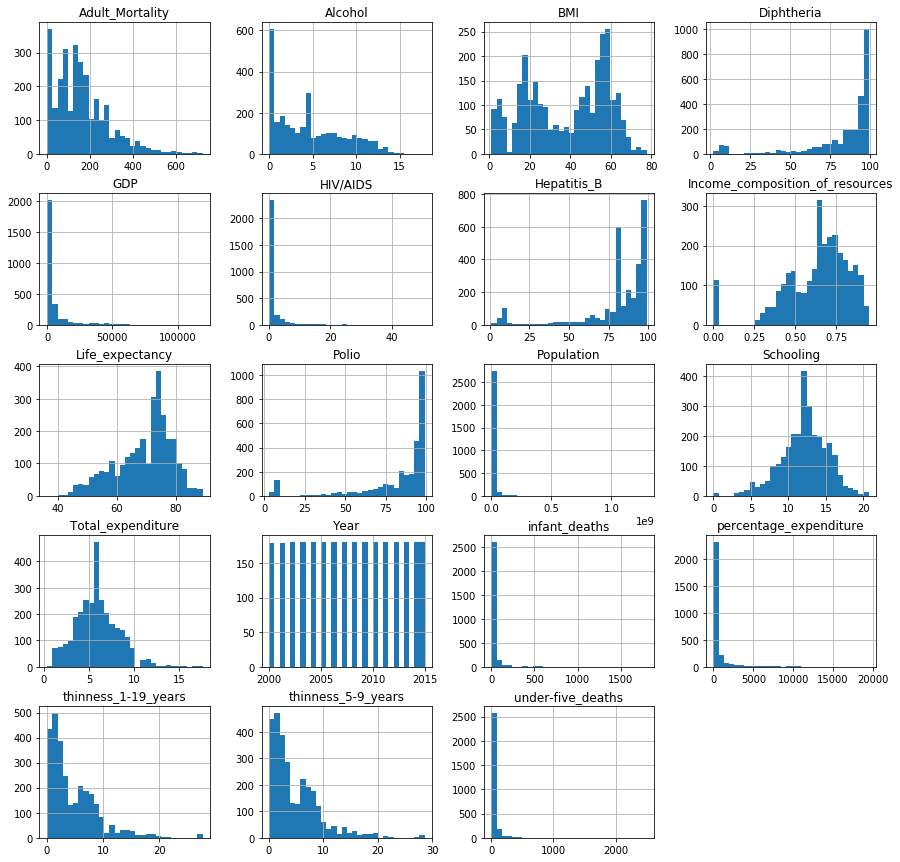

In [21]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_df = life_df.select_dtypes(include=numerics)
numeric_df.hist(bins=30, figsize=(15, 15))
plt.show()

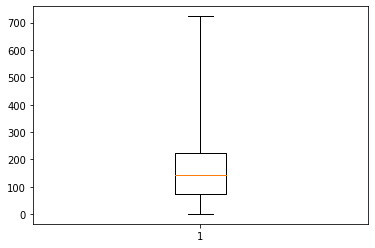

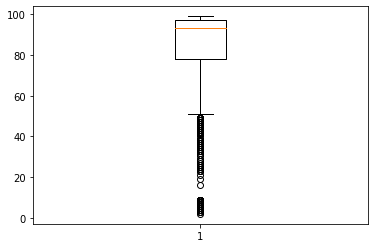

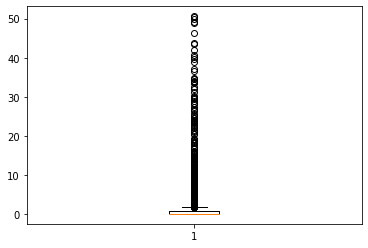

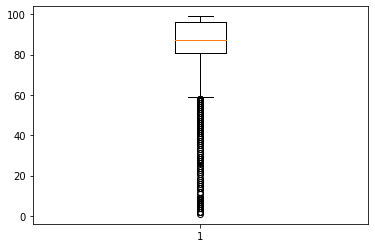

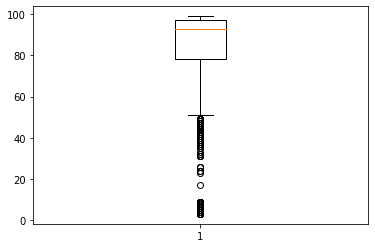

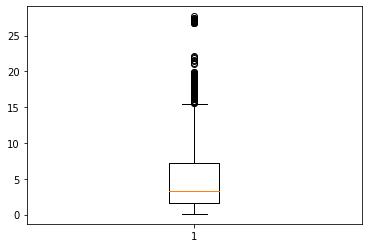

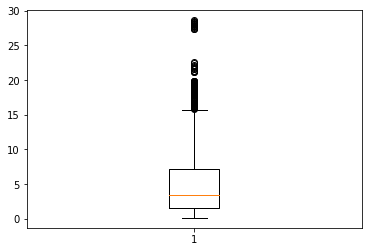

In [22]:
plt.boxplot(life_df['Adult_Mortality'], whis=300)
plt.show()
plt.boxplot(life_df['Diphtheria'])
plt.show()
plt.boxplot(life_df['HIV/AIDS'])
plt.show()
plt.boxplot(life_df['Hepatitis_B'])
plt.show()
plt.boxplot(life_df['Polio'])
plt.show()
plt.boxplot(life_df['thinness_1-19_years'])
plt.show()
plt.boxplot(life_df['thinness_5-9_years'])
plt.show()

## Z-scores to find and count outliers

In [23]:
z_scores = zscore(life_df["Adult_Mortality"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

234

In [24]:
z_scores = zscore(life_df["HIV/AIDS"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

132

In [25]:
z_scores = zscore(life_df["Hepatitis_B"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

0

In [26]:
z_scores = zscore(life_df["Polio"])
outliers = np.where(z_scores > 1)
len(outliers[0])

0

In [27]:
z_scores = zscore(life_df["thinness_1-19_years"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

232

In [28]:
z_scores = zscore(life_df["thinness_5-9_years"])
outliers = np.where(z_scores > 1.5)
len(outliers[0])

218

## Winsorize values

In [29]:
life_df['winsorize_mortal'] = winsorize(life_df["Adult_Mortality"], (0, 0.10))
life_df['winsorize_hiv'] = winsorize(life_df["HIV/AIDS"], (0, 0.10))
life_df['winsorize_thin1'] = winsorize(life_df["thinness_1-19_years"], (0, 0.10))
life_df['winsorize_thin2'] = winsorize(life_df["thinness_5-9_years"], (0, 0.10))
life_df

,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,BMI,...,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling,winsorize_mortal,winsorize_hiv,winsorize_thin1,winsorize_thin2
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,19.1,...,584.259210,33736494.0,17.2,17.3,0.479,10.1,263.0,0.1,9.8,9.7
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,18.6,...,612.696514,327582.0,17.5,17.5,0.476,10.0,271.0,0.1,9.8,9.7
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,18.1,...,631.744976,31731688.0,17.7,17.7,0.470,9.9,268.0,0.1,9.8,9.7
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,17.6,...,669.959000,3696958.0,17.9,18.0,0.463,9.8,272.0,0.1,9.8,9.7
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,17.2,...,63.537231,2978599.0,18.2,18.2,0.454,9.5,275.0,0.1,9.8,9.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,27.1,...,454.366654,12777511.0,9.4,9.4,0.407,9.2,334.0,4.5,9.4,9.4
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,26.7,...,453.351155,12633897.0,9.8,9.9,0.418,9.5,334.0,4.5,9.8,9.7
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,26.3,...,57.348340,125525.0,1.2,1.3,0.427,10.0,73.0,4.5,1.2,1.3
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,25.9,...,548.587312,12366165.0,1.6,1.7,0.427,9.8,334.0,4.5,1.6,1.7


## Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [30]:
life_df.describe()

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,BMI,under-five_deaths,Polio,...,GDP,Population,thinness_1-19_years,thinness_5-9_years,Income_composition_of_resources,Schooling,winsorize_mortal,winsorize_hiv,winsorize_thin1,winsorize_thin2
count,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,...,2888.000000,2.888000e+03,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000
mean,2007.515235,69.349377,163.357341,30.314751,4.643830,749.475611,81.022006,38.221087,41.985803,82.672091,...,6435.584156,9.973162e+06,4.850589,4.881337,0.632543,12.116312,153.564751,0.881683,4.348373,4.345291
std,4.606938,9.495441,124.018934,118.891670,3.928753,2003.090073,22.591590,19.962630,161.743345,23.333655,...,13505.460838,5.451825e+07,4.421403,4.510414,0.200414,3.107341,100.565212,1.452771,3.175503,3.172207
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,1.000000,0.000000,3.000000,...,0.000000,0.000000e+00,0.100000,0.100000,0.000000,0.000000,1.000000,0.100000,0.100000,0.100000
25%,2004.000000,63.475000,73.000000,0.000000,1.107500,5.049462,81.022006,19.300000,0.000000,78.000000,...,193.603049,5.409500e+03,1.600000,1.500000,0.511750,10.400000,73.000000,0.100000,1.600000,1.500000
50%,2008.000000,72.200000,143.000000,3.000000,4.165000,67.687008,87.000000,43.250000,4.000000,93.000000,...,1177.143989,5.266165e+05,3.350000,3.400000,0.666000,12.200000,143.000000,0.100000,3.350000,3.400000
75%,2012.000000,75.800000,225.000000,21.000000,7.490000,454.422430,96.000000,56.100000,26.000000,97.000000,...,4901.575091,4.570096e+06,7.200000,7.200000,0.774000,14.200000,225.000000,0.800000,7.200000,7.200000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,77.600000,2500.000000,99.000000,...,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000,334.000000,4.500000,9.800000,9.700000


In [31]:
life_df.columns

Index(['Country', 'Year', 'Status', 'Life_expectancy', 'Adult_Mortality',
       'infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B',
       'BMI', 'under-five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness_1-19_years',
       'thinness_5-9_years', 'Income_composition_of_resources', 'Schooling',
       'winsorize_mortal', 'winsorize_hiv', 'winsorize_thin1',
       'winsorize_thin2'],
      dtype='object')

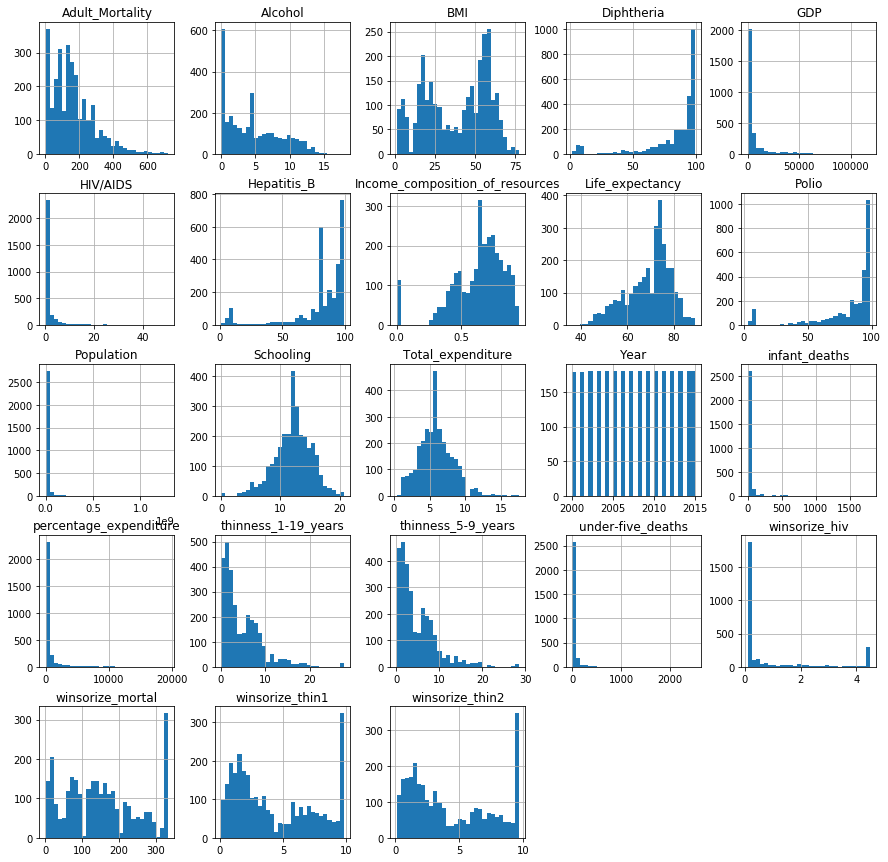

In [32]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_df = life_df.select_dtypes(include=numerics)
numeric_df.hist(bins=30, figsize=(15, 15))
plt.show()

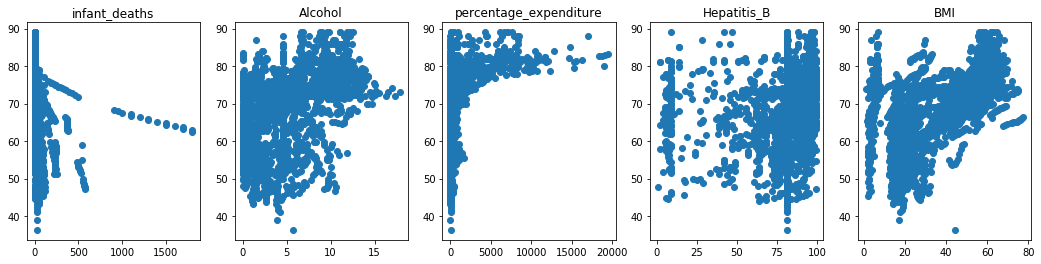

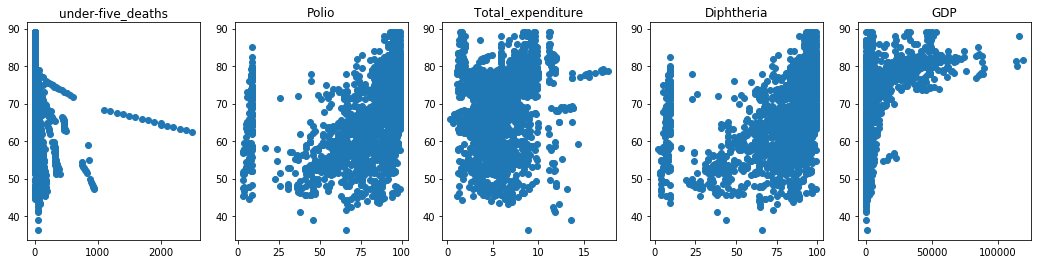

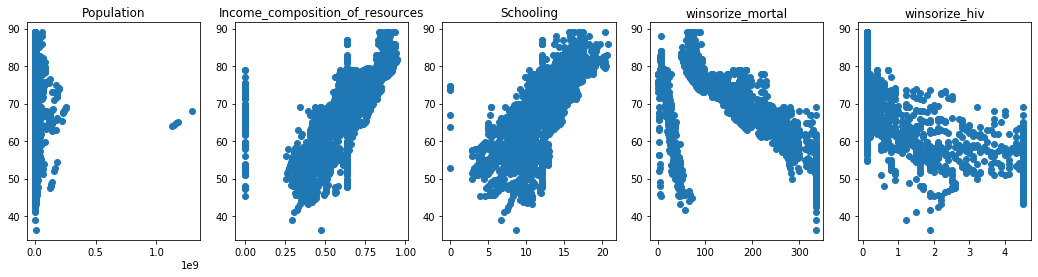

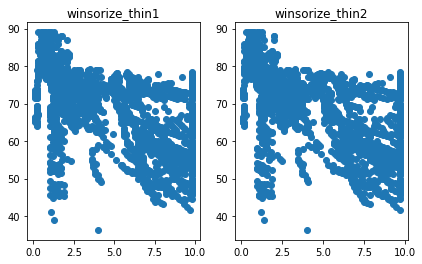

In [33]:
cols = ['infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B',
       'BMI', 'under-five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria', 
       'GDP', 'Population', 'Income_composition_of_resources', 'Schooling',
       'winsorize_mortal', 'winsorize_hiv', 'winsorize_thin1',
       'winsorize_thin2']

x = 1
plt.figure(figsize=(18,4))
for col in cols:
    plt.subplot(1,5,x)
    plt.scatter(life_df[col], life_df["Life_expectancy"])
    plt.title(col)
    
    if (x == 5):
        x = 1
        plt.show()
        plt.figure(figsize=(18,4))
    else:
        x += 1

## In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

## Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.